In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, PredictionErrorDisplay
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR


from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV


from tpot import TPOTRegressor


from textwrap import wrap
from functools import reduce

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf
from main.components.feature_importance_methods import rename_importnace_col, merge_feature_importances, rank_importances

import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [3]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
322,1,163.0,48.42,5.344538,71.0,173.0,23.722811,112.0,65.0,0.0,83.0,0.0,90.0,0.922222,1.0,1.0,0.479769,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,0.0,3.276000,3.990000,7.266000,0.0,0.0,10.61,7.11,17.72,1.0,0.0,0.0,4.30,2.29,1.50,0.39,0.09,0.03,53.2,34.9,9.1,2.1,0.7,4.56,13.4,39.1,2.917910,85.7,29.4,34.3,12.4,0.0,250.0,11.2,9.9,24.4,58.139535,0.039600,166.666667,3.846154,1.526667,0.348837,0.020930,142.0,4.39,9.36,4.69,0.91,1.2,14.0,18.0,0.34,180.0,4.65480,0.0,63.0,1.62918,0.0,96.3,2.490318,0.0,105.0,1.18545,0.0,1.528571,1.666667,1.392004,34.023121,29.63625,4.565649,0.221849,277.0,82.0,358.0,23.0,19.0,88.0,57.0,9.31,22.25,2.022914,10.32,0.343238,0.0,0.0,2.13,4.09,12.22,12.0,10.0,5.80,11.3,1.948276,174.0,236.0,1.0,0.288184,0.023585,93.689999,17.89,429.0,117.0,27.0,42.4,2.43,30.56,5.4,23.0,2.73,1.91,290.0,0.003448,0.366300,7.0,3.0,19.0
221,0,NaN,NaN,NaN,58.0,169.0,20.307412,NaN,NaN,NaN,69.0,0.0,78.0,0.884615,1.0,1.0,0.408284,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,6.885000,4.459000,11.344000,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,5.29,2.67,2.00,0.49,0.10,0.03,50.4,37.8,9.3,1.9,0.6,4.76,14.0,41.2,2.942857,86.6,29.4,34.0,13.3,0.0,170.0,15.7,11.7,39.2,32.136106,0.068824,85.000000,4.081633,1.335000,0.378072,0.018904,NaN,NaN,NaN,NaN,0.71,NaN,NaN,NaN,NaN,168.0,4.34448,0.0,63.0,1.62918,0.0,91.0,2.353260,0.0,69.0,0.77901,0.0,1.444444,1.095238,0.825936,28.153846,8.56911,4.344227,0.039509,NaN,NaN,NaN,NaN,NaN,86.0,

### Handle `vitamine D ` outliers

In [4]:
df[VITAMINE_D].mean()

25.551785714285714

In [5]:
df[VITAMINE_D].std()

12.965793597129847

In [6]:
25.5+13+13+13

64.5

In [7]:
df[df[VITAMINE_D] > 64.5][VITAMINE_D]

92      66.0
219     89.0
542     66.0
831     73.0
872     82.0
975    129.0
Name: vitamin 25-OH D ng/ml, dtype: float64

In [8]:
df.loc[df[VITAMINE_D] > 64.5, VITAMINE_D] = np.nan

<Axes: >

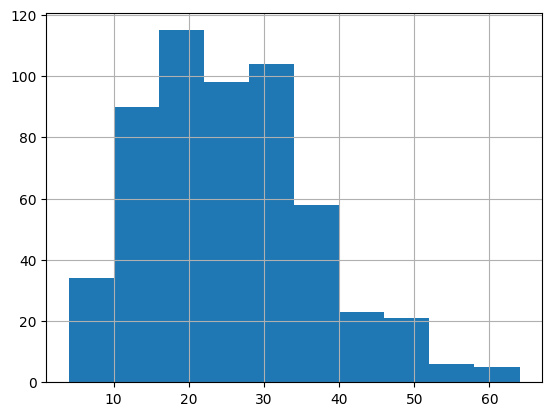

In [9]:
df[VITAMINE_D].hist()

# Model selection for vitamin D

In [10]:
df_vit_d_cleaned = df.dropna(subset=[VITAMINE_D])

X_vit_d, y_vit_d = df_vit_d_cleaned.drop(columns=[VITAMINE_D]), df_vit_d_cleaned[VITAMINE_D]
X_train_vit_d, X_test_vit_d, y_train_vit_d, y_test_vit_d = train_test_split(X_vit_d, y_vit_d, test_size=0.2, random_state=42)

In [26]:
models = [
        # DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        # Ridge(),
        # RandomForestRegressor(),
        ]

continuous_preprocessings = {
    # 'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    # 'PT_KNN_7': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=7))]),
    'PT_KNN_9_poly_2': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9)), ('poly',  PolynomialFeatures(degree=2))]),
    'PT_KNN_9_poly_2i': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9)), ('poly',  PolynomialFeatures(degree=2, interaction_only=True))]),
    'PT_KNN_9': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    # 'PT_KNN_10': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=10))]),
    # 'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    # 'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}

scores_df = explore_all_variations_of_preprocessing(X_train_vit_d, y_train_vit_d, VITAMINE_D, models, continuous_preprocessings, categorical_preprocessings)
scores_df

1/3 Lasso() PT_KNN_9_poly_2 original_ohe_no_imputing [-9.40793011 -8.1082119  -8.5256669  -8.85083228 -9.19181497 -9.6990181
 -8.29485549 -8.66844125 -8.12984807 -9.62865822 -8.56397021 -9.12869344
 -8.68440837 -8.29939832 -8.87443035] 8.803745198460174
2/3 Lasso() PT_KNN_9_poly_2i original_ohe_no_imputing [-9.16930612 -8.14580457 -8.51564701 -8.79167045 -8.45441257 -9.57462407
 -8.35691926 -8.47054272 -8.03815207 -9.5983016  -8.44153164 -9.11650267
 -8.64664058 -8.24830555 -8.9291798 ] 8.699836045982034
3/3 Lasso() PT_KNN_9 original_ohe_no_imputing [-9.0171995  -7.85439711 -8.44446215 -8.9343965  -8.47546644 -9.59332344
 -8.1857128  -8.1839464  -7.95983558 -9.16293201 -8.41338388 -8.64168462
 -8.85733913 -8.31069294 -8.84563813] 8.592027374784234


,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_KNN_9_poly_2,original_ohe_no_imputing,Lasso(),8.803745
1,PT_KNN_9_poly_2i,original_ohe_no_imputing,Lasso(),8.699836
2,PT_KNN_9,original_ohe_no_imputing,Lasso(),8.592027


In [21]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
Lasso()                    8.976081
RandomForestRegressor()    8.930126
Name: MAE, dtype: float64

In [22]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    8.883338
                          original_ohe_+_impute_rf     8.899515
                          original_ohe_no_imputing     8.844582
PT_iterative_basic        original_ohe_+_impute_knn    8.901165
                          original_ohe_+_impute_rf     8.914229
                          original_ohe_no_imputing     8.925448
RS_KNN                    original_ohe_+_impute_knn    9.007031
                          original_ohe_+_impute_rf     9.005657
                          original_ohe_no_imputing     8.990216
RS_iterative_basic        original_ohe_+_impute_knn    9.004354
                          original_ohe_+_impute_rf     9.024740
                          original_ohe_no_imputing     9.036970
Name: MAE, dtype: float64

In [11]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
DecisionTreeRegressor(max_depth=7, random_state=42)    11.816821
Lasso()                                                 9.060178
RandomForestRegressor()                                 9.037357
Ridge()                                                11.497512
Name: MAE, dtype: float64

In [7]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    10.206016
                          original_ohe_+_impute_rf     10.142260
                          original_ohe_no_imputing     10.221180
PT_iterative_basic        original_ohe_+_impute_knn    10.169115
                          original_ohe_+_impute_rf     10.208578
                          original_ohe_no_imputing     10.249406
RS_KNN                    original_ohe_+_impute_knn    10.495360
                          original_ohe_+_impute_rf     10.508968
                          original_ohe_no_imputing     10.596368
RS_iterative_basic        original_ohe_+_impute_knn    10.476707
                          original_ohe_+_impute_rf     10.430341
                          original_ohe_no_imputing     10.531306
Name: MAE, dtype: float64

In [8]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    10.106080
                          original_ohe_+_impute_rf     10.134701
                          original_ohe_no_imputing     10.057171
PT_iterative_basic        original_ohe_+_impute_knn    10.101045
                          original_ohe_+_impute_rf     10.086042
                          original_ohe_no_imputing     10.052659
RS_KNN                    original_ohe_+_impute_knn    10.118658
                          original_ohe_+_impute_rf     10.109679
                          original_ohe_no_imputing     10.055548
RS_iterative_basic        original_ohe_+_impute_knn    10.121895
                          original_ohe_+_impute_rf     10.170401
                          original_ohe_no_imputing     10.066486
Name: MAE, dtype: float64

In [9]:
scores_df.groupby(by=['continuous_preprocessing'])['MAE'].mean()

continuous_preprocessing
PT_KNN                10.099317
PT_iterative_basic    10.079915
RS_KNN                10.094628
RS_iterative_basic    10.119594
Name: MAE, dtype: float64

In [10]:
scores_df.groupby(by=['categorical_pteprocessing'])['MAE'].mean()

categorical_pteprocessing
original_ohe_+_impute_knn    10.111920
original_ohe_+_impute_rf     10.125206
original_ohe_no_imputing     10.057966
Name: MAE, dtype: float64

In [11]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
DecisionTreeRegressor(max_depth=7, random_state=42)    11.364120
Lasso()                                                 8.830515
RandomForestRegressor()                                 8.975628
Ridge()                                                11.223191
Name: MAE, dtype: float64

Best preprocessing techniques for vitamine D:
- PT_KNN  + original_ohe_no_imputing

In [11]:
from sklearn.discriminant_analysis import StandardScaler

tree_continuous_preprocessing = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))])
linear_continuous_preprocessor =  Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9)), ('poly',  PolynomialFeatures(degree=2, interaction_only=True))])

# continuous_preprocessor = Pipeline([('scaler', StandardScaler()), ('imputer', KNNImputer(n_neighbors=9))])
# linear_continuous_preprocessor =  Pipeline([('scaler', StandardScaler()), ('imputer', KNNImputer(n_neighbors=9)), ('poly',  PolynomialFeatures(degree=2, interaction_only=True))])


categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])

### Hyperparameter tuning

### Lasso

Fitting 15 folds for each of 9 candidates, totalling 135 fits


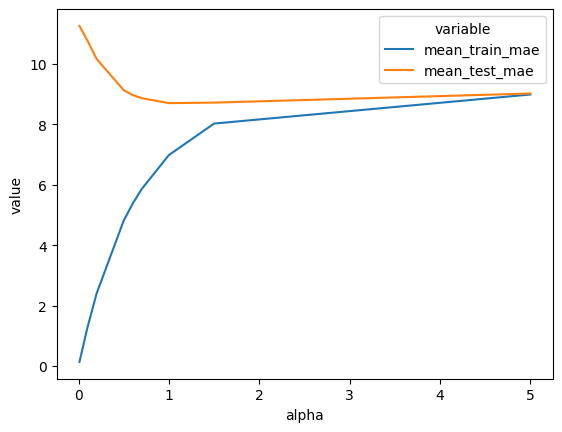

,alpha,mean_train_mae,mean_test_mae
0,0.01,0.138468,11.254155
1,0.1,1.292734,10.759708
2,0.2,2.402725,10.162138
3,0.5,4.815211,9.129411
4,0.6,5.379774,8.966038
5,0.7,5.861999,8.863027
6,1,6.982568,8.699836
7,1.5,8.023460,8.716766
8,5,8.985761,9.018594


In [28]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 1, 1.5, 5],
}

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Lasso(), linear_continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

Fitting 15 folds for each of 9 candidates, totalling 135 fits


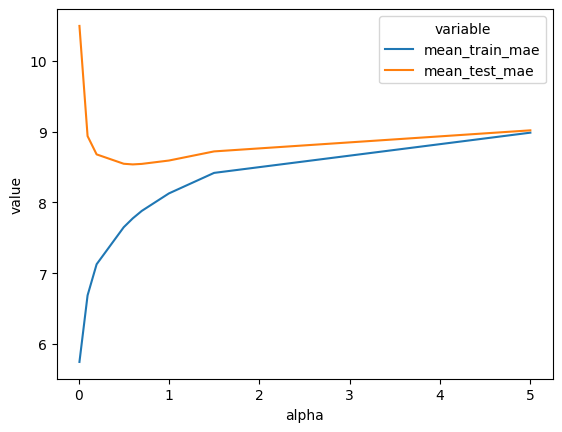

,alpha,mean_train_mae,mean_test_mae
0,0.01,5.746966,10.493781
1,0.1,6.687528,8.937024
2,0.2,7.126772,8.678879
3,0.5,7.649897,8.546469
4,0.6,7.774955,8.537318
5,0.7,7.880766,8.544606
6,1,8.127568,8.592027
7,1.5,8.417539,8.721012
8,5,8.985761,9.018594


In [13]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 1, 1.5, 5],
    }

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

Selected alpha: 0.2

### Ridge

Fitting 15 folds for each of 12 candidates, totalling 180 fits


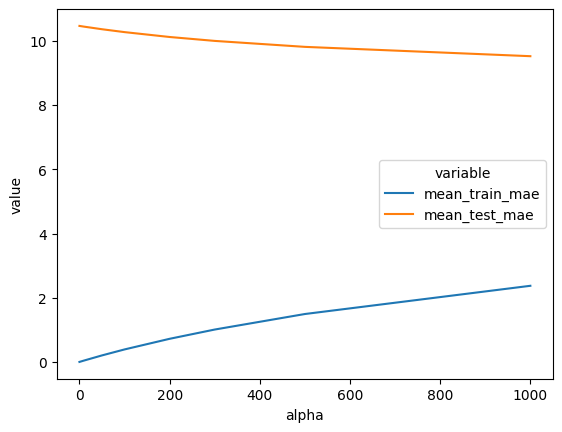

,alpha,mean_train_mae,mean_test_mae
0,0.000001,4.250580e-09,10.465631
1,0.01,4.250539e-05,10.465608
2,0.1,4.250174e-04,10.465406
3,1,4.246529e-03,10.463386
4,10,4.210551e-02,10.443505
5,50,2.030030e-01,10.362488
6,100,3.890657e-01,10.272676
7,200,7.202285e-01,10.120817
8,300,1.008492e+00,9.999063
9,500,1.492202e+00,9.813286


In [31]:
ridge_param_grid = {
    "model__alpha": [0.000001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 500, 1000, 1000],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Ridge(), linear_continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Fitting 15 folds for each of 6 candidates, totalling 90 fits


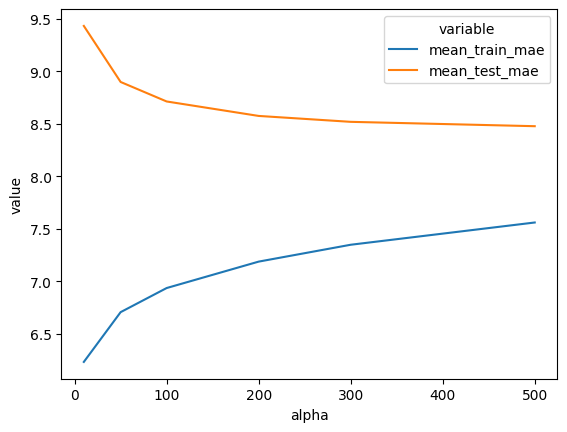

,alpha,mean_train_mae,mean_test_mae
0,10,6.233465,9.432432
1,50,6.707366,8.898773
2,100,6.936897,8.713139
3,200,7.188481,8.575460
4,300,7.349015,8.519250
5,500,7.560861,8.477752


In [23]:
ridge_param_grid = {
    "model__alpha": [10, 50, 100, 200, 300, 500],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Best alpha: 50 lub 100

### DecisionTreeRegressor

In [35]:
tree_model = DecisionTreeRegressor()

tree_param_grid = {
    "model__criterion": ["absolute_error"],
    "model__max_depth": [8, 9, 10, 12],
    "model__splitter": ["random", "best"],
    "model__min_samples_split": [15, 16, 17, 20],
    "model__min_samples_leaf": [20, 22, 25, 27],
    }

vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, tree_model, continuous_preprocessor, categorical_preprocessor, tree_param_grid)
vit_d_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 128 candidates, totalling 1920 fits


,params,mean_train_mae,mean_test_mae
94,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 20, 'model__splitter': 'random'}",8.051596,9.153658
114,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 25, 'model__min_samples_split': 16, 'model__splitter': 'random'}",7.931328,9.171357
22,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}",7.933408,9.227749
16,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",7.942298,9.232884
42,"{'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 22, 'model__min_samples_split': 16, 'model__splitter': 'random'}",7.891790,9.258377
18,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 16, 'model__splitter': 'random'}",8.009245,9.266767
28,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17, 'model__splitter': 'random'}",8.021903,9.289721
122,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16, 'model__splitter': 'random'}",8.007836,9.298851
92,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17, 'model__splitter': 'random'}",8.023786,9.300637
112,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",8.011512,9.333725


In [11]:
model = DecisionTreeRegressor(criterion="absolute_error", max_depth=10, min_samples_leaf=27, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


,cv_mae
62,-9.07908
58,-9.187412
14,-9.191769
51,-9.192326
83,-9.193849


### Random Forest

In [42]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [3, 5, 7],
    'model__min_samples_leaf': [3, 5, 7],
}

vit_d_rf_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, RandomForestRegressor(criterion="absolute_error"), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
vit_d_rf_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 18 candidates, totalling 270 fits


,params,mean_train_mae,mean_test_mae
8,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}",6.047948,8.726923
15,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}",6.544893,8.740124
1,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 200}",5.119564,8.741829
17,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 200}",6.547260,8.743113
16,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 100}",6.558310,8.747370
7,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 200}",6.049708,8.749739
14,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 100}",6.570497,8.753219
13,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}",6.547810,8.758884
9,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}",6.038521,8.759326
10,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 7, 'model__n_estimators': 100}",6.066576,8.763497


In [43]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, max_features='sqrt', min_samples_leaf=5, min_samples_split=5, criterion='absolute_error')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:45<00:00,  5.92s/it]


,cv_mae
13,-8.697161
16,-8.713622
7,-8.714204
61,-8.714876
72,-8.717986


#### SVR

In [36]:


param_grid_svr = {
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': [0.1, 1, 10],
    'model__degree': [2],
    'model__epsilon': [0.1, 0.2, 0.3],
}

vit_d_rf_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, SVR(), continuous_preprocessor, categorical_preprocessor, param_grid_svr)
vit_d_rf_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 108 candidates, totalling 1620 fits


,params,mean_train_mae,mean_test_mae
20,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 0.1, 'model__kernel': 'poly'}",2.071792,8.949483
11,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 0.1, 'model__kernel': 'poly'}",2.009152,8.962450
2,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 0.1, 'model__kernel': 'poly'}",1.946509,8.975060
79,"{'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 10, 'model__kernel': 'rbf'}",2.352481,8.993824
76,"{'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 1, 'model__kernel': 'rbf'}",2.352481,8.993824
73,"{'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 0.1, 'model__kernel': 'rbf'}",2.352458,8.993856
67,"{'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 1, 'model__kernel': 'rbf'}",2.290825,8.994061
70,"{'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 10, 'model__kernel': 'rbf'}",2.290825,8.994061
64,"{'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 0.1, 'model__kernel': 'rbf'}",2.290797,8.994093
61,"{'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 10, 'model__kernel': 'rbf'}",2.228893,8.994287


## Best models for Vitamine D

#### Linear Regression

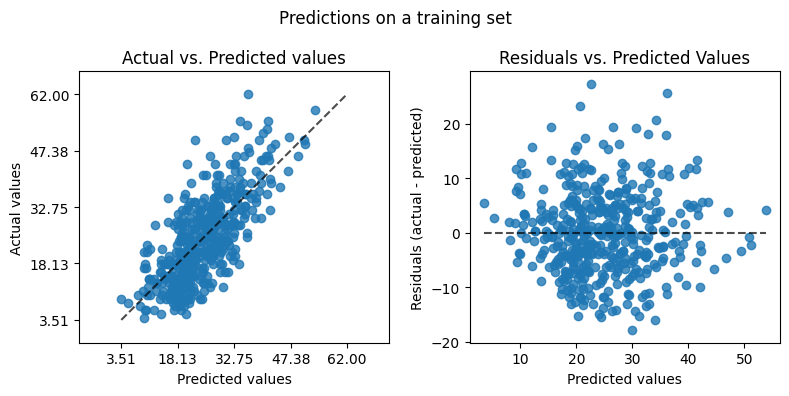

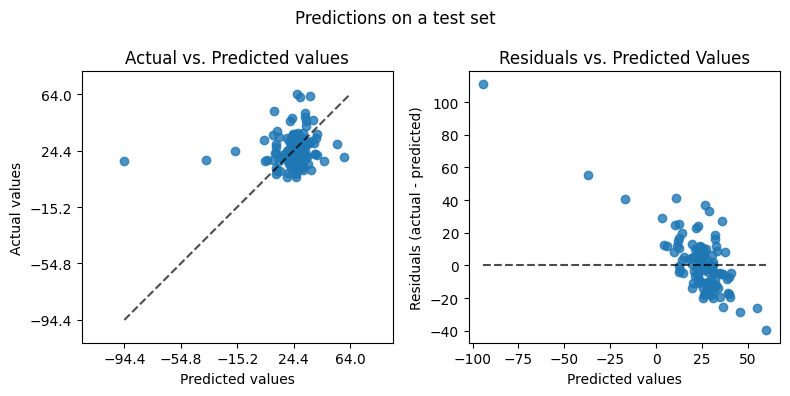

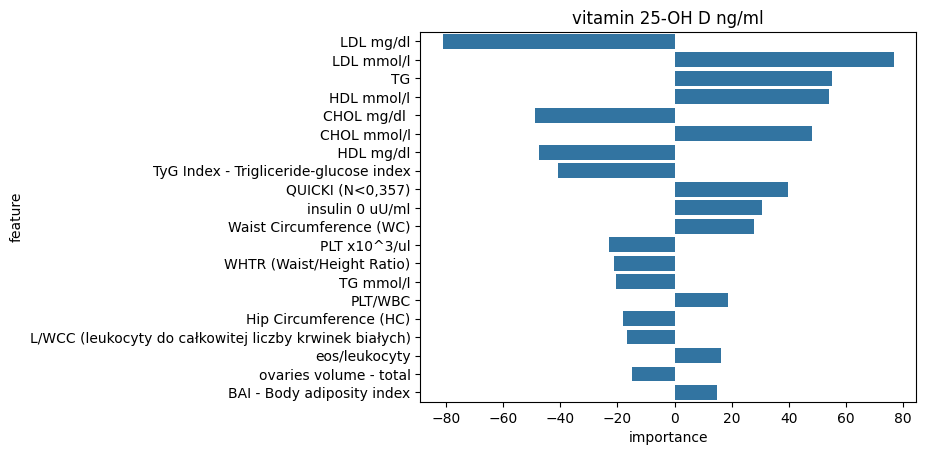

,model,data_set,mse,mae,rmse,r2
0,LinearRegression(),training,57.441,6.010,7.579,0.533
1,LinearRegression(),test,354.497,12.957,18.828,-1.511


In [12]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lasso = train_model(lr_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

#### Linear Regression with Polynomial Features

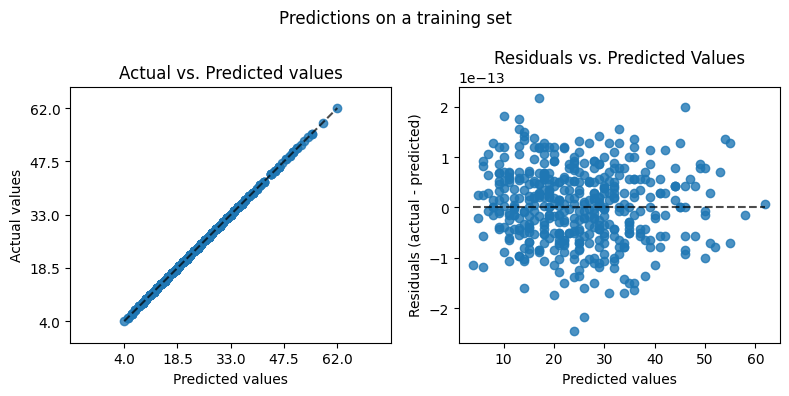

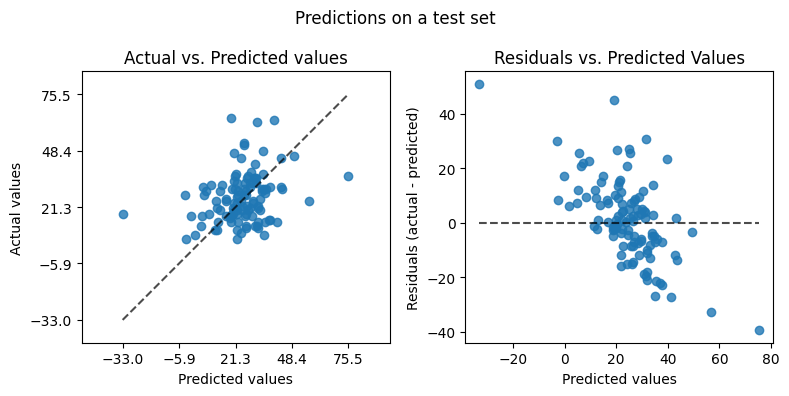

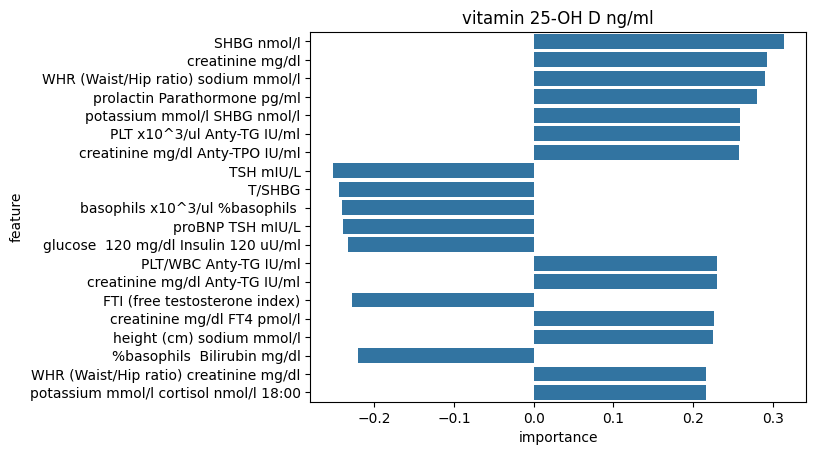

,model,data_set,mse,mae,rmse,r2
0,LinearRegression(),training,0.000,0.000,0.000,1.000
1,LinearRegression(),test,223.183,11.248,14.939,-0.581


In [13]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lasso = train_model(lr_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, linear_continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

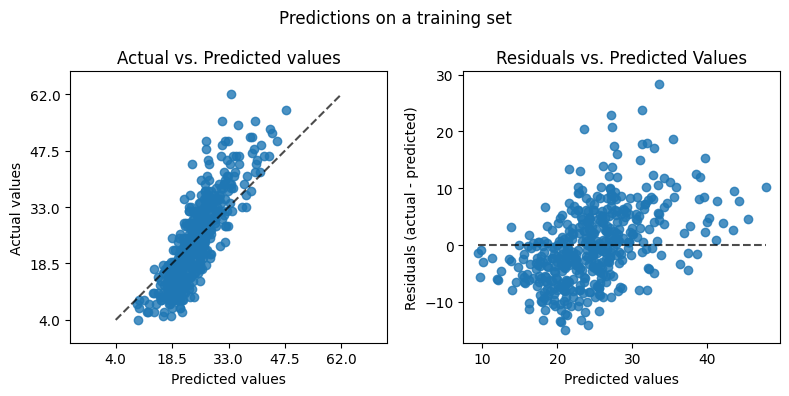

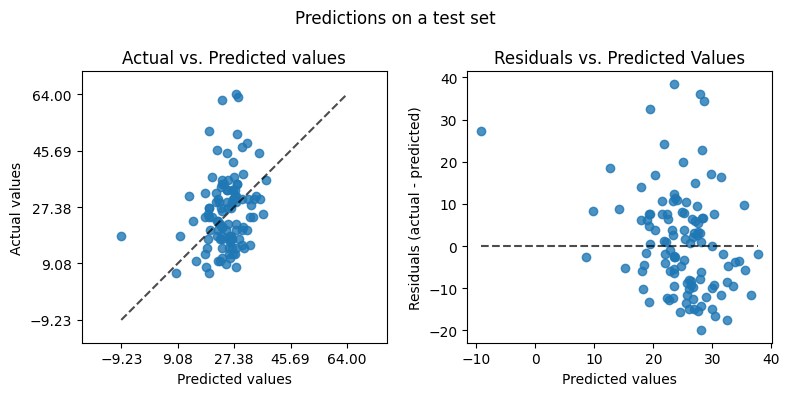

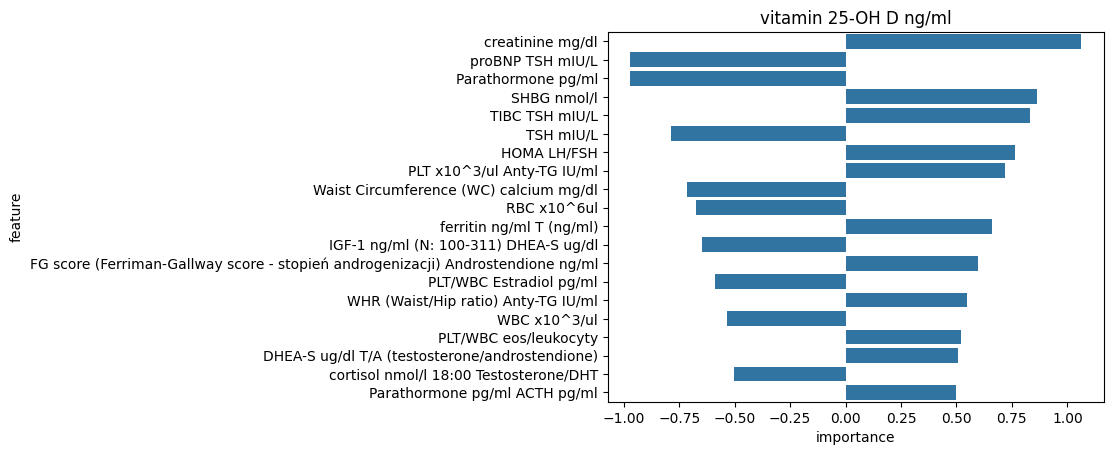

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=0.5),training,46.240,5.358,6.800,0.624
1,Lasso(alpha=0.5),test,145.756,9.501,12.073,-0.032


In [14]:
poly_lasso_model = Lasso(alpha=0.5)

vit_d_model_scores_df, feature_importnces_lasso = train_model(poly_lasso_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, linear_continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

### Lasso without polynomial features

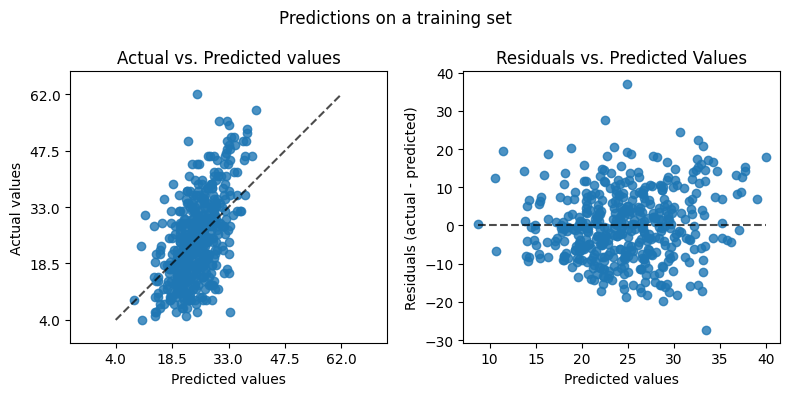

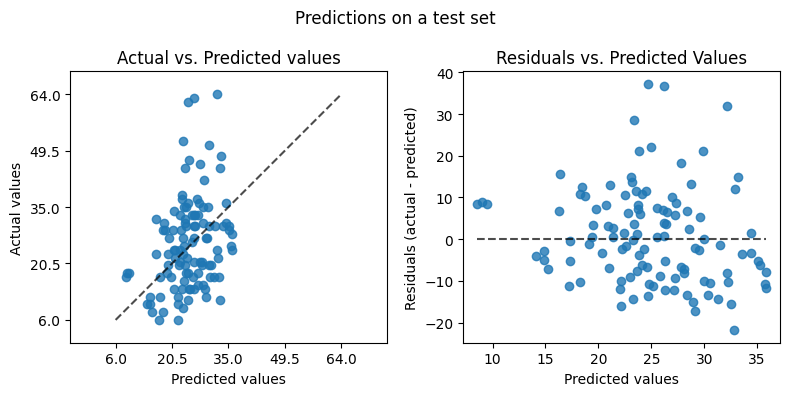

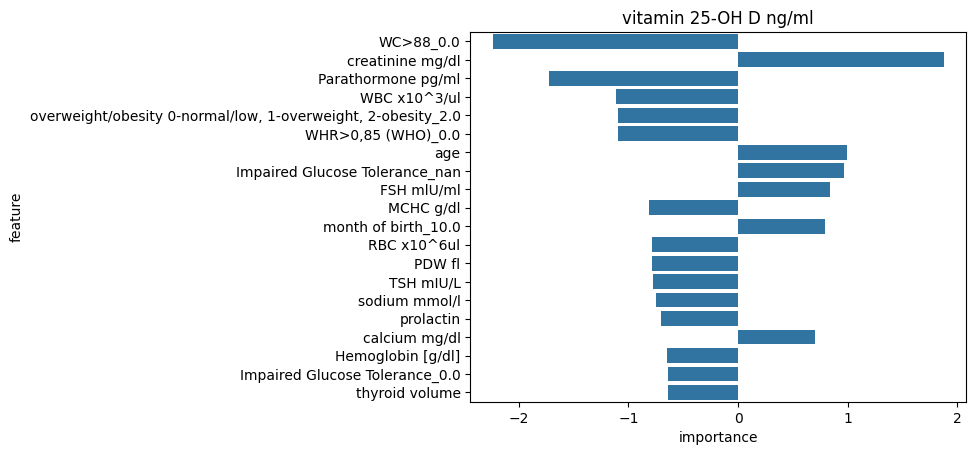

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=0.2),training,84.168,7.347,9.174,0.316
1,Lasso(alpha=0.2),test,132.258,9.142,11.500,0.063


In [15]:
lasso_model = Lasso(alpha=0.2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

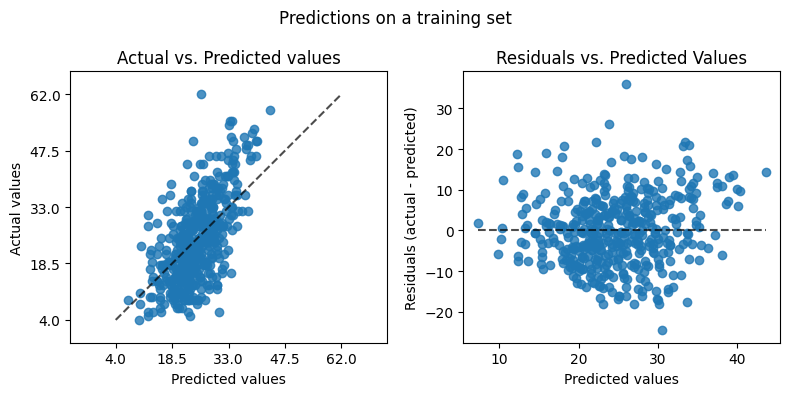

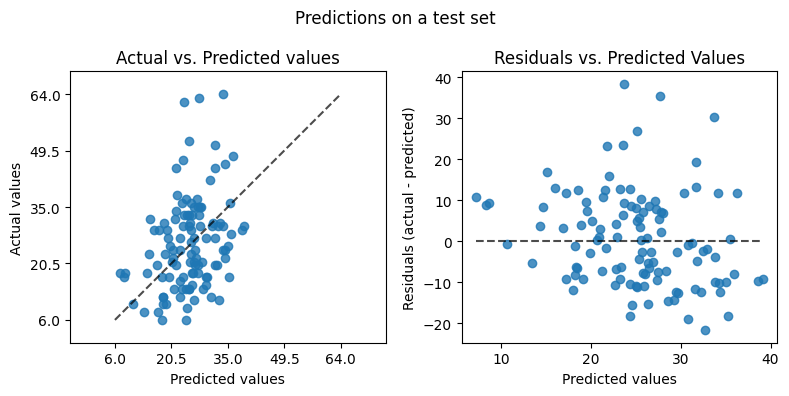

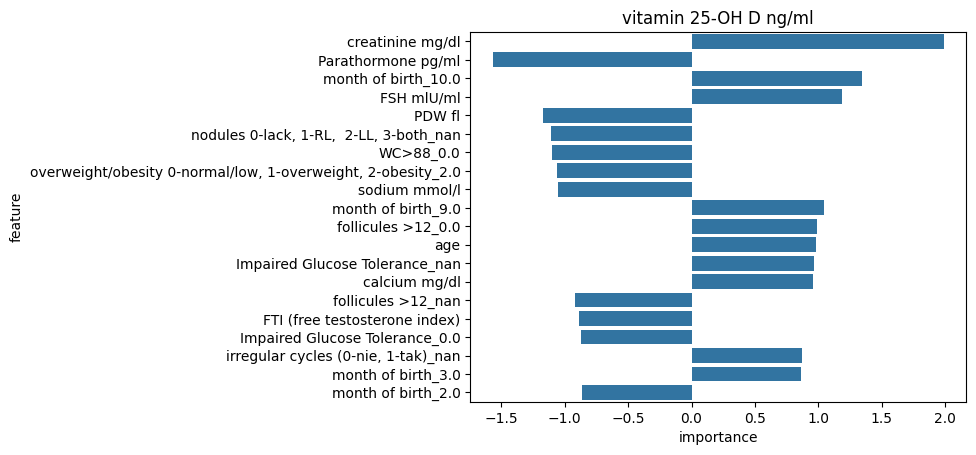

,model,data_set,mse,mae,rmse,r2
0,Ridge(alpha=50),training,74.618,6.930,8.638,0.394
1,Ridge(alpha=50),test,134.662,9.386,11.604,0.046


In [16]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

### Decision Tree

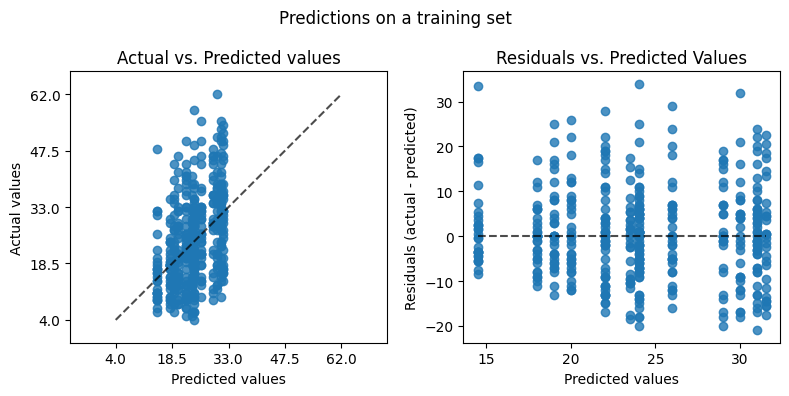

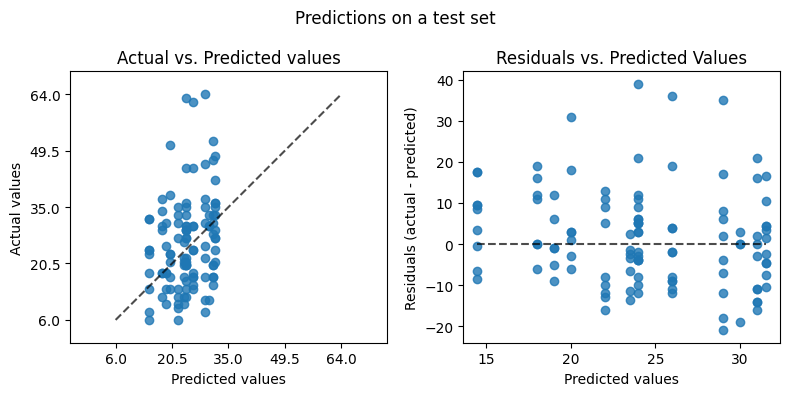

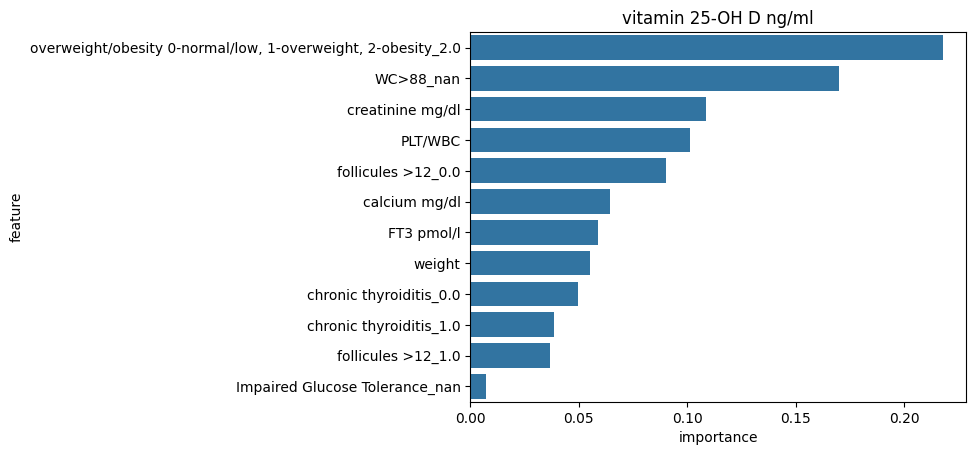

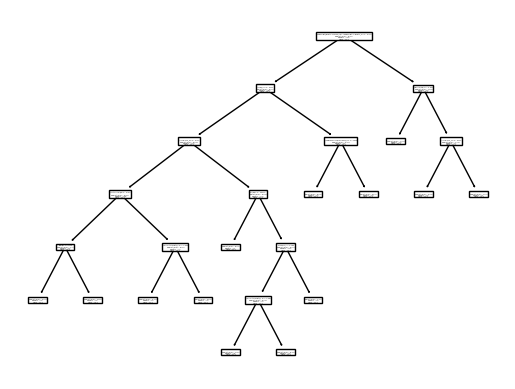

,model,data_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(criterion='absolute_error', max_depth=10,\n min_samples_leaf=27, min_samples_split=15,\n random_state=62, splitter='random')",training,101.687,7.731,10.084,0.174
1,"DecisionTreeRegressor(criterion='absolute_error', max_depth=10,\n min_samples_leaf=27, min_samples_split=15,\n random_state=62, splitter='random')",test,137.863,9.023,11.741,0.024


In [17]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=10, min_samples_leaf=27, min_samples_split=15, splitter='random', random_state=62)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, tree_continuous_preprocessing, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

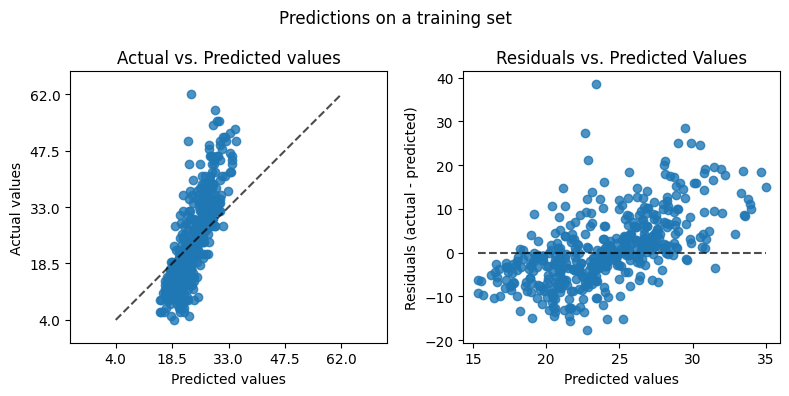

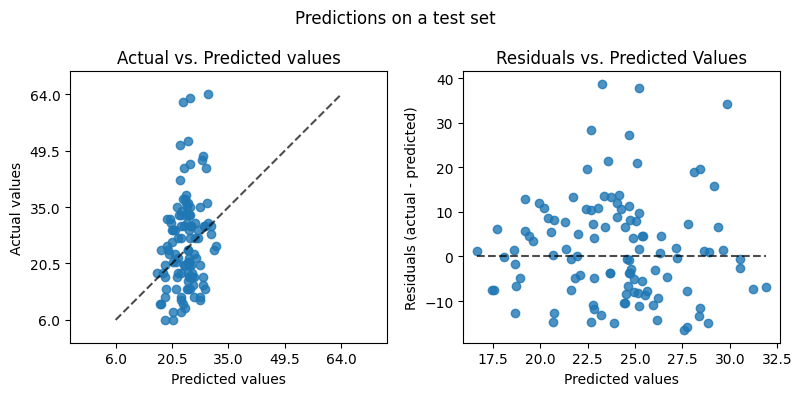

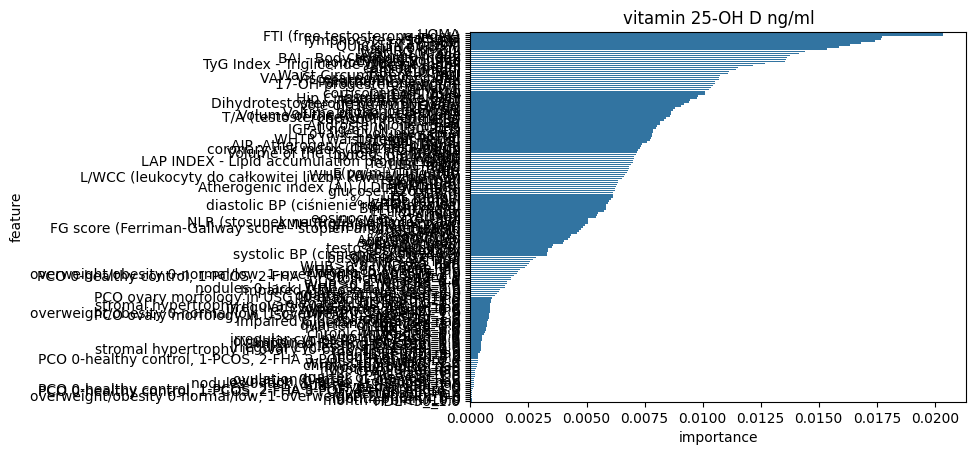

,model,data_set,mse,mae,rmse,r2
0,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",training,68.193,6.275,8.258,0.446
1,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",test,135.327,9.018,11.633,0.042


In [18]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, tree_continuous_preprocessing, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df

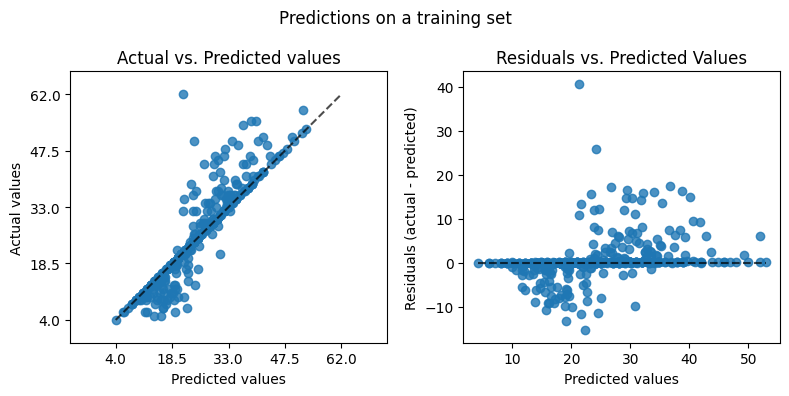

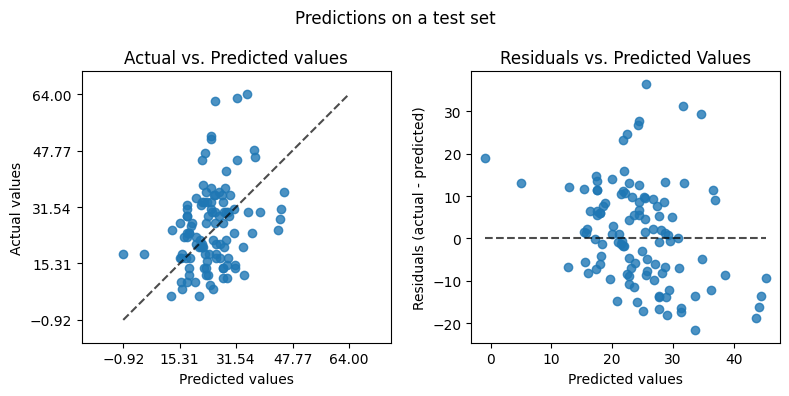

TypeError: 'NoneType' object is not callable

In [19]:
svm_model = SVR(C=0.1, degree=2, epsilon=0.1, gamma=0.1, kernel='poly')
vit_d_model_scores_df, feature_importnces_sv = train_model(svm_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, None)
vit_d_model_scores_df

## Feature importances


In [20]:
rename_importnace_col(feature_importnces_lasso, 'lasso')
rename_importnace_col(feature_importnces_ridge, 'ridge')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'rf')

feature_importance_df = merge_feature_importances([feature_importnces_lasso, feature_importnces_ridge, feature_importnces_tree, feature_importnces_rf])
feature_importance_df.head(5)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance
0,HDL mg/dl,NaN,-0.046623,NaN,0.006325
1,% lymphocytes,NaN,-0.149272,NaN,0.005954
2,% monocytes,NaN,0.036240,NaN,0.004304
3,% neutrophil,0.503705,0.520125,NaN,0.004783
4,%basophils,NaN,0.026389,NaN,0.004606


In [21]:
ranked_df = rank_importances(feature_importance_df)
ranked_df.head(5)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
0,HDL mg/dl,52.0,195.0,13.0,76.0,84.00
1,% lymphocytes,52.0,157.0,13.0,84.0,76.50
2,% monocytes,52.0,200.0,13.0,102.0,91.75
3,% neutrophil,25.0,60.0,13.0,98.0,49.00
4,%basophils,52.0,205.0,13.0,100.0,92.50


In [22]:
ranked_df.sort_values(by='lasso_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
109,WC>88_0.0,1.0,7.0,13.0,124.0,36.25
136,creatinine mg/dl,2.0,1.0,3.0,12.0,4.50
84,Parathormone pg/ml,3.0,2.0,13.0,25.0,10.75
108,WBC x10^3/ul,4.0,26.0,13.0,10.0,13.25
193,"overweight/obesity 0-normal/low, 1-overweight, 2-obesity_2.0",5.0,8.0,1.0,120.0,33.50
116,"WHR>0,85 (WHO)_0.0",6.0,21.0,13.0,138.0,44.50
127,age,7.0,12.0,13.0,11.0,10.75
52,Impaired Glucose Tolerance_nan,8.0,13.0,12.0,143.0,44.00
30,FSH mlU/ml,9.0,4.0,13.0,75.0,25.25
64,MCHC g/dl,10.0,48.0,13.0,74.0,36.25


In [23]:
ranked_df.sort_values(by='ridge_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
136,creatinine mg/dl,2.0,1.0,3.0,12.0,4.50
84,Parathormone pg/ml,3.0,2.0,13.0,25.0,10.75
172,month of birth_10.0,11.0,3.0,13.0,182.0,52.25
30,FSH mlU/ml,9.0,4.0,13.0,75.0,25.25
80,PDW fl,13.0,5.0,13.0,80.0,27.75
189,"nodules 0-lack, 1-RL, 2-LL, 3-both_nan",52.0,6.0,13.0,174.0,61.25
109,WC>88_0.0,1.0,7.0,13.0,124.0,36.25
193,"overweight/obesity 0-normal/low, 1-overweight, 2-obesity_2.0",5.0,8.0,1.0,120.0,33.50
207,sodium mmol/l,15.0,9.0,13.0,104.0,35.25
182,month of birth_9.0,52.0,10.0,13.0,184.0,64.75


In [24]:
ranked_df.sort_values(by='tree_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
193,"overweight/obesity 0-normal/low, 1-overweight, 2-obesity_2.0",5.0,8.0,1.0,120.0,33.50
111,WC>88_nan,52.0,51.0,2.0,115.0,55.00
136,creatinine mg/dl,2.0,1.0,3.0,12.0,4.50
83,PLT/WBC,52.0,34.0,4.0,37.0,31.75
145,follicules >12_0.0,45.0,11.0,5.0,122.0,45.75
129,calcium mg/dl,17.0,14.0,6.0,18.0,13.75
31,FT3 pmol/l,38.0,76.0,7.0,6.0,31.75
214,weight,43.0,121.0,8.0,62.0,58.50
130,chronic thyroiditis_0.0,52.0,23.0,9.0,149.0,58.25
131,chronic thyroiditis_1.0,52.0,75.0,10.0,119.0,64.00


In [25]:
ranked_df.sort_values(by='rf_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
38,HOMA,52.0,210.0,13.0,1.0,69.00
33,FTI (free testosterone index),21.0,16.0,13.0,2.0,13.00
68,Matsuda,52.0,117.0,13.0,3.0,46.25
169,lymphocytes x10^3/ul,52.0,86.0,13.0,4.0,38.75
91,T/SHBG,52.0,38.0,13.0,5.0,27.00
31,FT3 pmol/l,38.0,76.0,7.0,6.0,31.75
85,"QUICKI (N<0,357)",33.0,124.0,13.0,7.0,44.25
164,insulin 0 uU/ml,52.0,201.0,13.0,8.0,68.50
88,SHBG nmol/l,23.0,95.0,13.0,9.0,35.00
108,WBC x10^3/ul,4.0,26.0,13.0,10.0,13.25


In [26]:
ranked_df.sort_values(by='average_rank').head(15)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
136,creatinine mg/dl,2.0,1.0,3.0,12.0,4.50
84,Parathormone pg/ml,3.0,2.0,13.0,25.0,10.75
127,age,7.0,12.0,13.0,11.0,10.75
33,FTI (free testosterone index),21.0,16.0,13.0,2.0,13.00
108,WBC x10^3/ul,4.0,26.0,13.0,10.0,13.25
129,calcium mg/dl,17.0,14.0,6.0,18.0,13.75
99,TSH mIU/L,14.0,37.0,13.0,29.0,23.25
30,FSH mlU/ml,9.0,4.0,13.0,75.0,25.25
101,TyG Index - Trigliceride-glucose index,24.0,49.0,13.0,16.0,25.50
91,T/SHBG,52.0,38.0,13.0,5.0,27.00


Most important attributes for `vitamin D`: 'creatinine mg/dl', 'Parathormone pg/ml', 'FTI (free testosterone index)', `WBC x10^3/ul	`, `calcium mg/dl	`, `age`

## Feature selection methods

In [27]:
selector = VarianceThreshold(threshold=0.009)
selector.set_output(transform='pandas')
selector.fit_transform(X_train_vit_d)

kept_features_mask = selector.get_support()

print("Usunięte cechy:", [X_train_vit_d.columns[i] for i, keep in enumerate(kept_features_mask) if not keep])

Usunięte cechy: ['WHR (Waist/Hip ratio)', 'WHTR (Waist/Height Ratio)', 'basophils x10^3/ul', 'NRBC x10^3/ul', 'MPV/PLT', 'L/WCC (leukocyty do całkowitej liczby krwinek białych)', 'eos/leukocyty', 'QUICKI (N<0,357)', 'T/SHBG', 'Testosterone/DHT']


### SelectKBest

In [28]:

def feature_selection(feature_selection_model, X_train, y_train):
    preprocessor = ColumnTransformer(
        verbose_feature_names_out=False,
        transformers=[
            ('num', continuous_preprocessor, get_continuous_attributes_except(VITAMINE_D)),
            ('cat', categorical_preprocessor, CATEGORICAL_ATTRIBUTES)
        ])
    pipeline = Pipeline([('preprocessor', preprocessor), ('feature_selection', feature_selection_model)])

    X_new = pipeline.fit_transform(X_train, y_train)

    selected_indices = feature_selection_model.get_support(indices=True)
    selected_feature_names = [preprocessor.get_feature_names_out()[i] for i in selected_indices]
    print(selected_feature_names)

    return pd.DataFrame(X_new, columns=selected_feature_names)


feature_selection(SelectKBest(mutual_info_regression, k=10), X_train_vit_d, y_train_vit_d) #!!


feature_selection(SelectKBest(f_regression, k=10), X_train_vit_d, y_train_vit_d)


feature_selection(SelectKBest(r_regression, k=10), X_train_vit_d, y_train_vit_d).head()

['IGF-1 ng/ml (N: 100-311)', 'BMI', 'Hip Circumference (HC)', 'RBC x10^6ul', 'PDW fl', 'MPV fl', 'PLT/WBC', 'T/SHBG', 'Estradiol pg/ml', 'FTI (free testosterone index)']
['WBC x10^3/ul', 'RBC x10^6ul', 'creatinine mg/dl', 'insulin 0 uU/ml', 'HOMA', 'Matsuda', 'QUICKI (N<0,357)', 'T/SHBG', 'SHBG nmol/l', 'FTI (free testosterone index)']
['PLT/WBC', 'creatinine mg/dl', ' HDL mg/dl', 'HDL mmol/l', 'Matsuda', 'QUICKI (N<0,357)', 'SHBG nmol/l', 'WHTR>0,5_nan', 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity_0.0', 'Impaired Glucose Tolerance_nan']


,PLT/WBC,creatinine mg/dl,HDL mg/dl,HDL mmol/l,Matsuda,"QUICKI (N<0,357)",SHBG nmol/l,"WHTR>0,5_nan","overweight/obesity 0-normal/low, 1-overweight, 2-obesity_0.0",Impaired Glucose Tolerance_nan
0,0.640699,-0.259190,-1.425206,-1.427444,-1.682011,-1.770734,-1.704907,0.0,0.0,0.0
1,0.300659,-0.460975,0.731468,0.735195,-0.598077,-0.540816,-0.480803,0.0,0.0,0.0
2,0.424817,1.071877,-1.425206,-1.427444,-0.539344,-1.233502,-1.391970,0.0,0.0,0.0
3,0.961915,-0.460975,-2.020467,-2.009462,-2.313110,-2.514346,0.542096,0.0,0.0,0.0
4,-1.761709,0.423460,0.621510,0.624697,0.413783,0.950276,-1.144061,0.0,1.0,0.0


### Recursive feature elimination

Optimal number of features: 19
['thyroid volume' 'Vole of the Right Ovary' 'Volume of the  Left Ovary'
 'ovaries volume - total' 'WBC x10^3/ul' 'neutrophil x10^3/ul'
 'lymphocytes x10^3/ul' 'monocytes x10^3/ul' 'eosinocytes x10^3/ul'
 'RBC x10^6ul' 'PLT/WBC' 'PLR' 'calcium mg/dl' 'creatinine mg/dl'
 'insulin 0 uU/ml' 'TSH mIU/L' 'FT3 pmol/l' 'T/SHBG' 'Parathormone pg/ml']


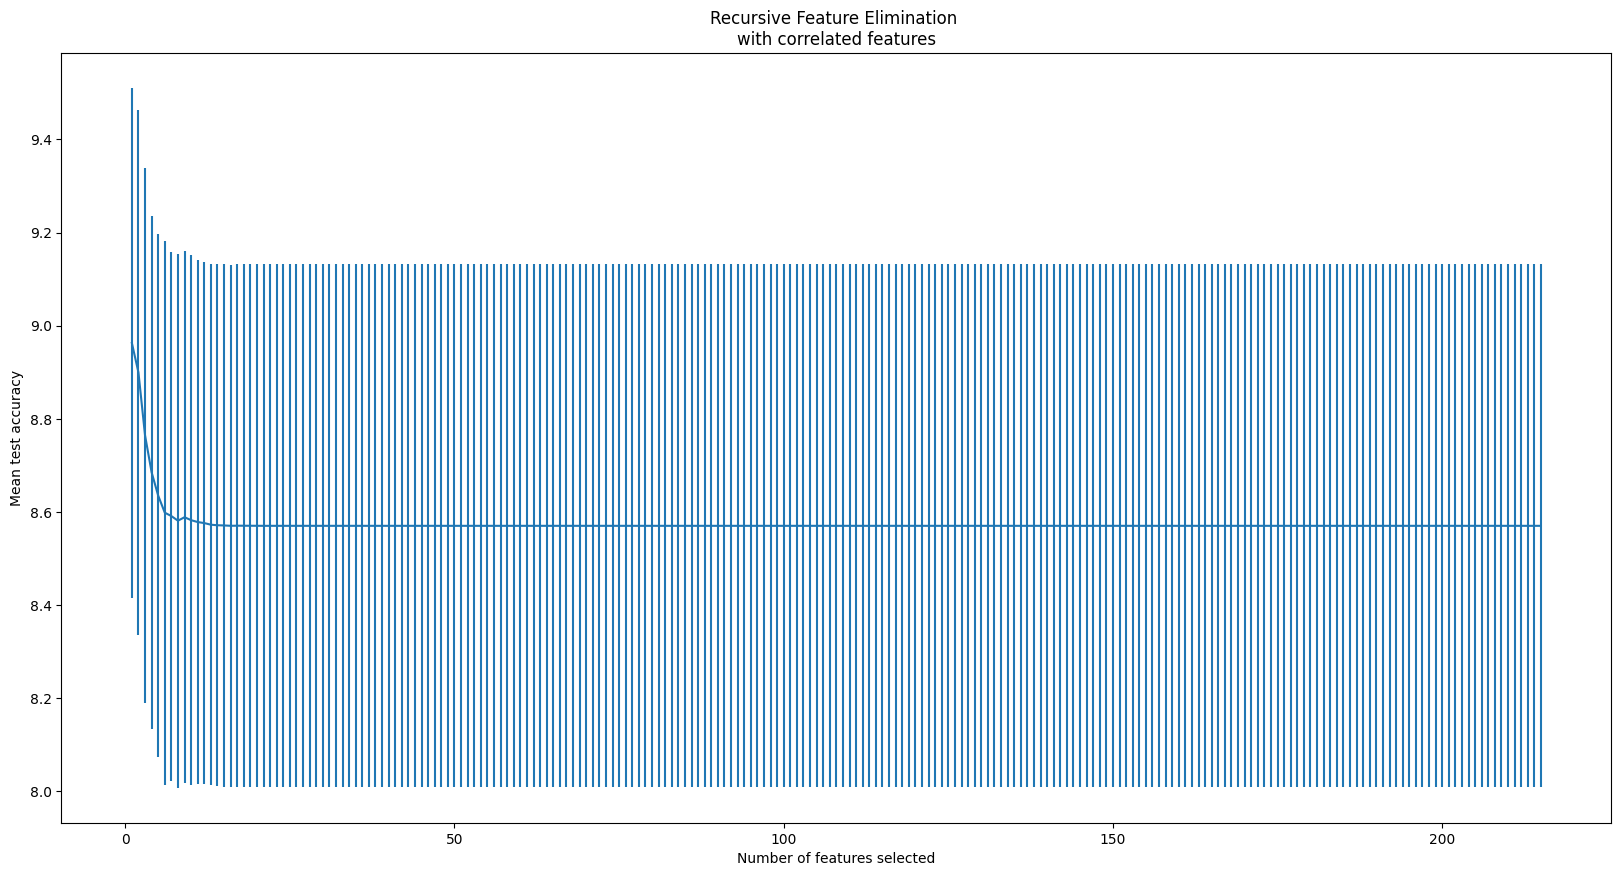

In [29]:
preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ('num', continuous_preprocessor, get_continuous_attributes_except(VITAMINE_D)),
        ('cat', categorical_preprocessor, CATEGORICAL_ATTRIBUTES)
    ])


min_features_to_select = 1
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
rfecv = RFECV(
    estimator=Lasso(), # rf
    step=1,
    cv=cv,
    scoring="neg_mean_absolute_error",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

pipeline = Pipeline([('preprocessor', preprocessor), ('fs', rfecv)])
pipeline.fit(X_train_vit_d, y_train_vit_d)

selected_feature_indices = rfecv.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]

# print(len(preprocessor.get_feature_names_out()))
print(f"Optimal number of features: {rfecv.n_features_}")
# print(rfecv.get_feature_names_out())
print(selected_feature_names)

n_scores = len(rfecv.cv_results_["mean_test_score"])
scores = abs(rfecv.cv_results_["mean_test_score"])

plt.figure(figsize=(20,10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    scores,
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### SelectFromModel

In [53]:
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
sel_from_model = SelectFromModel(
    estimator=Lasso(),
)

pipeline = Pipeline([('preprocessor', preprocessor), ('sel_from_model', sel_from_model)])
pipeline.fit(X_train_vit_d, y_train_vit_d)

selected_feature_indices = sel_from_model.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
selected_feature_names

array(['thyroid volume', 'WBC x10^3/ul', 'RBC x10^6ul', 'PLT/WBC', 'PLR',
       'calcium mg/dl', 'creatinine mg/dl', 'insulin 0 uU/ml',
       'TSH mIU/L', 'FT3 pmol/l', 'T/SHBG', 'Parathormone pg/ml'],
      dtype=object)

### Permutation importance

In [61]:
pipeline = Pipeline([('preprocessor', preprocessor), ('model', Lasso(alpha=0.5))])
pipeline.fit(X_train_vit_d, y_train_vit_d)

result = permutation_importance(pipeline, X_train_vit_d, y_train_vit_d, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean

feature_importances = dict(zip(preprocessor.get_feature_names_out(), importances))

sorted_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)

df_importances = pd.DataFrame(sorted_importances, columns=['feature', 'importance'])

df_importances.head(15)

,feature,importance
0,UIBC ug/dl,0.057920
1,"WHR>0,85 (WHO)_1.0",0.051269
2,sodium mmol/l,0.019722
3,T/A (testosterone/androstendione),0.014822
4,"ovulation (0-brak, 1-obecna)_0.0",0.011190
5,PLT x10^3/ul,0.010216
6,RBC x10^6ul,0.009751
7,TyG Index - Trigliceride-glucose index,0.007859
8,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro_3",0.006554
9,"WHTR>0,5_0.0",0.005572


## TPOT

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
tpot = TPOTRegressor(generations=5, population_size=50, cv=cv, verbosity=2, random_state=42, scoring='r2', n_jobs=-1)
tpot.fit(X_train_vit_d, y_train_vit_d)

print(tpot.fitted_pipeline_)

print("Score on test set:", tpot.score(X_test_vit_d, y_test_vit_d))

tpot.export('tpot_pipeline.py')

In [31]:

cv = RepeatedKFold(n_splits=5, n_repeats=3)
tpot = TPOTRegressor(generations=5, population_size=50, cv=cv, verbosity=2, random_state=42, scoring='neg_mean_absolute_error', n_jobs=-1)
tpot.fit(X_train_vit_d, y_train_vit_d)

# Wyświetlenie najlepszego znalezionego rurociągu
print(tpot.fitted_pipeline_)

# Ocena modelu na zbiorze testowym
print("Score on test set:", tpot.score(X_test_vit_d, y_test_vit_d))

# Eksportowanie optymalnego rurociągu do pliku Pythona
tpot.export('tpot_pipeline.py')

Imputing missing values in feature set
                                                                              
Generation 1 - Current best internal CV score: -8.435646067190696
                                                                              
Generation 2 - Current best internal CV score: -8.435646067190696
                                                                              
Generation 3 - Current best internal CV score: -8.435646067190696
                                                                              
Generation 4 - Current best internal CV score: -8.435646067190696
                                                                              
Generation 5 - Current best internal CV score: -8.435646067190696
                                                           
Best pipeline: RandomForestRegressor(ElasticNetCV(input_matrix, l1_ratio=0.75, tol=0.01), bootstrap=True, max_features=0.4, min_samples_leaf=16, min_samples_split=14, n_estimat